# Liquid State Machine with SpiNNaker

- I've been tweaking the .spynnaker.cfg file to slow down SpiNNaker by increasing the timeScaleFactor to 10. This way it will have more resources to deal with the input/output spikes... I hope!

In [1]:
# plotter in python
%matplotlib notebook
import matplotlib.pyplot as plt

import time
import numpy

import save_load_file as slf

In [2]:
import sys
import BEE # see https://github.com/ricardodeazambuja/LiquidStateMachine-Python

In [3]:
net_shape = numpy.array([20,5,6])

membrane_rand=[13.5E-3,14.9E-3]
current_rand=[13.5E-09, 14.5E-09]

noisy_current_rand=1E-18 #1E-9 # NO NOISY CURRENT TO MAKE IT COMPATIBLE WITH SPINNAKER

factor=10E6 #2*10.0 # VIRTUALLY NO NOISY RESET VOLTAGES TO MAKE IT COMPATIBLE WITH SPINNAKER

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution

lbd_value = 1.2

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]


# Neuron parameters
taum=0.03 # membrane time constant
cm=3e-08 # membrane capacitance
taue=0.003 # excitatory synapse time constant
taui=0.006 # inhibitory synapse time constant


time_step = 2/1000.

number_of_threads = 5

In [4]:
# 
# Defines how many liquids
# 
number_of_liquids = 5

# 
# Generates the seeds used to generate the liquids
# 
# rng_seed=123
# rng = numpy.random.RandomState(rng_seed)
# liqseeds = []
# for i in range(number_of_liquids):
#     liqseeds.append(numpy.array(rng.randint(0,10000,6),dtype=numpy.uint32))
#     print "Liquid %d:" % i, liqseeds[i]

liqseeds = slf.load_from_file_gz("liqseeds.gzpickle")
number_of_liquids = len(liqseeds)
for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [8504 6373 6528 9820 4728 5408]
Liquid 1: [6878 1704 9127 4863 8948 3511]
Liquid 2: [ 214 9852 3943 8654 8283 5606]
Liquid 3: [4730  341 4093 7541  811  467]
Liquid 4: [3202  913 4191 4309 9239 8001]


In [5]:
pop_lsm_exc = []
pop_lsm_inh = []

input_synapses_exc = []
input_synapses_inh = []

exc_neuron_idx = []

inh_neuron_idx = []

total_size_exc = 0
total_size_inh = 0

i_offset_exc = []
i_offset_inh = []

init_membrane_v_exc = []
init_membrane_v_inh = []

connections_pre_e = []
connections_pos_e = []
weights_pre_e = []

connections_pre_i = []
connections_pos_i = []
weights_pre_i = []

total_exc2_conn = 0
total_inh2_conn = 0


for lsm_i in range(number_of_liquids):
    
    print "Processing liquid number:", lsm_i

    if BEE.BEE_initialized():
        # Resets the simulator
        BEE.BEE_free()

    if not BEE.BEE_initialized():
        print "initializing BEE..."
        BEE.initialize_sim(my_net_shape = net_shape, \
                       my_lbd_value = lbd_value, \
                       my_seeds=liqseeds[lsm_i], \
                       SpkLiq_step=time_step,\
                       SpkLiq_threads_N = number_of_threads,\
                       SpkLiq_vresets = SpkLiq_vresets_rand,\
                       SpkLiq_membrane_rand=membrane_rand,\
                       SpkLiq_current_rand=current_rand,\
                       SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                       SpkLiq_noisy_current_rand=noisy_current_rand)


    if parameter_list!=[]:
        BEE.change_parameters(parameter_list)

    if BEE.BEE_initialized() and (not BEE.BEE_connected()):
        BEE.generate_connections()

    if BEE.BEE_initialized() and (not BEE.BEE_connected()):
        BEE.process_connections()

    NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=BEE.output_stats(stats=0)
    # NofN: total number of neurons
    # NoINHN: total number of inhibitory neurons
    # NoEXCN: total number of excitatory neurons
    # NoINHC: total number of inhibitory connections
    # NoEXCC: total number of excitatory connections
    
    print "Liquid->Liquid connections and parameters"
    
    #
    # The populations (exc and inh) are ordered as the arrays (exc_neuron_idx and inh_neuron_idx) below:
    #
    
    exc_neuron_idx.append(BEE.output_exc_indices(NoEXCN))
    # exc_neuron_idx[spinnaker_index]=>BEE_index
    total_size_exc += len(exc_neuron_idx[-1]) # [-1] because I'm appending each time the loop runs...
    # SpiNNaker will have two populations: one with excitatory and another with inhibitory neurons.
    # Since I have more than one liquid, I need to add to obtain the total number of neurons.

    inh_neuron_idx.append(BEE.output_inh_indices(NoINHN))
    # inh_neuron_idx[spinnaker_index]=>BEE_index
    total_size_inh += len(inh_neuron_idx[-1])

    i_offset = BEE.output_noisy_offsets(NofN)*1E9 # SpiNNaker uses nA
    i_offset_exc.append(i_offset[exc_neuron_idx[-1]])
    i_offset_inh.append(i_offset[inh_neuron_idx[-1]])


    init_membrane_v = BEE.output_initial_voltages(NofN)*1E3 # SpiNNaker uses mV
    init_membrane_v_exc.append(init_membrane_v[exc_neuron_idx[-1]])
    init_membrane_v_inh.append(init_membrane_v[inh_neuron_idx[-1]])
    
    connections_pre_e.append(BEE.output_pre_e_connections(NoEXCC))
    connections_pos_e.append(BEE.output_pos_e_connections(NoEXCC))
    weights_pre_e.append(BEE.output_pre_e_weights(NoEXCC))    
    total_exc2_conn+=len(connections_pre_e[-1])
    
    connections_pre_i.append(BEE.output_pre_i_connections(NoINHC))
    connections_pos_i.append(BEE.output_pos_i_connections(NoINHC))
    weights_pre_i.append(BEE.output_pre_i_weights(NoINHC))
    total_inh2_conn+=len(connections_pre_i[-1])
    
    # Resets the simulator
    BEE.BEE_free()

total_size=total_size_exc+total_size_inh

print
print "Total number of neurons:",  total_size
print "Total number of neurons LSM_EXC population:",  total_size_exc
print "Total number of neurons LSM_INH population:",  total_size_inh

print "Total number of EXC2ANY connections:",  total_exc2_conn
print "Total number of INH2ANY connections:",  total_inh2_conn

Processing liquid number: 0
initializing BEE...
BEE_setup done!
Liquid->Liquid connections and parameters
Processing liquid number: 1
initializing BEE...
BEE_setup done!
Liquid->Liquid connections and parameters
Processing liquid number: 2
initializing BEE...
BEE_setup done!
Liquid->Liquid connections and parameters
Processing liquid number: 3
initializing BEE...
BEE_setup done!
Liquid->Liquid connections and parameters
Processing liquid number: 4
initializing BEE...
BEE_setup done!
Liquid->Liquid connections and parameters

Total number of neurons: 3000
Total number of neurons LSM_EXC population: 2400
Total number of neurons LSM_INH population: 600
Total number of EXC2ANY connections: 4537
Total number of INH2ANY connections: 1284


In [6]:
#
# Converts from the SpiNNaker internal populations indices to BEE individual liquids/indices.
#
# SpiNNaker will always have two only two populations for all liquids: 
# - one excitatory and one inhibitory.
from_spinnaker_exc2bee = [[lsm_i, spnkr_exc_idx] for lsm_i,exc_lsm in enumerate(exc_neuron_idx) 
                                                      for spnkr_exc_idx in exc_lsm]
from_spinnaker_inh2bee = [[lsm_i, spnkr_inh_idx] for lsm_i,inh_lsm in enumerate(inh_neuron_idx) 
                                                      for spnkr_inh_idx in inh_lsm]

# Example:
# SpiNNaker excitatory neuron with index 10 => [BEE_lsm_i,BEE_index]
from_spinnaker_exc2bee[10]

[0, 14]

In [7]:
#
# Converts from lsm_i/BEE to SpiNNaker internal populations
#

# from_bee2spinnaker[lsm_i][bee_idx]=>['exc/inh',idx]
from_bee2spinnaker = [range(NofN) for i in range(number_of_liquids)]

for i,(lsm_i,idx) in enumerate(from_spinnaker_exc2bee):
    from_bee2spinnaker[lsm_i][idx]=['exc',i]

for i,(lsm_i,idx) in enumerate(from_spinnaker_inh2bee):
    from_bee2spinnaker[lsm_i][idx]=['inh',i]
    
# Example:
# BEE liquid number 0 and neuron index 440 => ['exc' or 'inh', neuron_index]
from_bee2spinnaker[0][440]

['inh', 81]

In [8]:
# Saves the arrays to be used by the receiver/sender
numpy.save('from_spinnaker_exc2bee.npy',from_spinnaker_exc2bee)
numpy.save('from_spinnaker_inh2bee.npy',from_spinnaker_inh2bee)

# Saves the arrays to be used by the receiver/sender
numpy.save('from_bee2spinnaker.npy',from_bee2spinnaker)

In [9]:
#
# These are the cell (neuron) parameters
#
cell_params_lsm = {'cm'          : 30,    # Capacitance of the membrane
                   'i_offset'    : 0.0,   # Offset current
                   'tau_m'       : 30.0,  # Membrane time constant
                   'tau_refrac_E': 3.0,   # Duration of refractory period - EXCITATORY
                   'tau_refrac_I': 2.0,   # Duration of refractory period - INHIBITORY
                   'tau_syn_E'   : 3.0,   # Decay time of excitatory synaptic current
                   'tau_syn_I'   : 6.0,   # Decay time of inhibitory synaptic current
                   'v_reset'     : 13.5,  # Reset potential after a spike
                   'v_rest'      : 0.0,   # Resting membrane potential
                   'v_thresh'    : 15.0,  # Spike threshold
                   'i_noise'     : 0.2    # mean 0 and SD=0.2nA
                }


# Parameter of the neuron model LIF with exponential currents 
# (SpiNNaker does NOT accept to individualy vary the refractory period)
cell_params_lif_exc = {
                         'tau_m': cell_params_lsm['tau_m'],
                         'cm': cell_params_lsm['cm'],
                         'v_rest': cell_params_lsm['v_rest'],
                         'v_reset': cell_params_lsm['v_reset'],
                         'v_thresh': cell_params_lsm['v_thresh'],
                         'tau_syn_E': cell_params_lsm['tau_syn_E'],
                         'tau_syn_I': cell_params_lsm['tau_syn_I'],
                         'tau_refrac': cell_params_lsm['tau_refrac_E'],
                         'i_offset': cell_params_lsm['i_offset'],
                      }
# The only difference is the refractory period
cell_params_lif_inh = {
                         'tau_m': cell_params_lsm['tau_m'],
                         'cm': cell_params_lsm['cm'],
                         'v_rest': cell_params_lsm['v_rest'],
                         'v_reset': cell_params_lsm['v_reset'],
                         'v_thresh': cell_params_lsm['v_thresh'],
                         'tau_syn_E': cell_params_lsm['tau_syn_E'],
                         'tau_syn_I': cell_params_lsm['tau_syn_I'],
                         'tau_refrac': cell_params_lsm['tau_refrac_I'],
                         'i_offset': cell_params_lsm['i_offset'],
                      }

In [10]:
# imports of both spynnaker and external device plugin.
import spynnaker.pyNN as spnkr
import spynnaker_external_devices_plugin.pyNN as ExternalDevices

#######################
# import to allow prefix type for the prefix eieio protocol
######################
from spynnaker_external_devices_plugin.pyNN.connections\
    .spynnaker_live_spikes_connection import SpynnakerLiveSpikesConnection

In [11]:
# initial call to set up the front end (pynn requirement)
spnkr_timestep = time_step*1E3 # SpiNNaker uses ms

spnkr.setup(timestep=spnkr_timestep) #, min_delay=1.0, max_delay=144.0)

0

In [12]:
# Creates two separated populations: one for excitatory neurons and other for inhibitory
# It's necessary to divide excitatory and inhibitory neurons because it's not possible to set
# different values for the refractory period inside the same population 
# (Is that still true for 3.0.0???)
pop_lsm_exc = spnkr.Population(total_size_exc, spnkr.IF_curr_exp, cell_params_lif_exc, label='LSM_EXC')

pop_lsm_inh = spnkr.Population(total_size_inh, spnkr.IF_curr_exp, cell_params_lif_inh, label='LSM_INH')

In [13]:
# Initialises some parameters individually for each neuron.
pop_lsm_exc.tset('i_offset',[i for j in i_offset_exc for i in j])
pop_lsm_inh.tset('i_offset',[i for j in i_offset_inh for i in j])

pop_lsm_exc.initialize('v',[i for j in init_membrane_v_exc for i in j])
pop_lsm_inh.initialize('v',[i for j in init_membrane_v_inh for i in j])

In [14]:
# Activate the SENDING of live spikes from the pop_lsm_exc
ExternalDevices.activate_live_output_for(
    pop_lsm_exc, 
    database_notify_host="localhost",
    database_notify_port_num=12346)

# Activate the SENDING of live spikes from the pop_lsm_inh
ExternalDevices.activate_live_output_for(
    pop_lsm_inh, 
    database_notify_host="localhost",
    database_notify_port_num=12346)

In [15]:
connected_internally = True

internal_delay = spnkr_timestep

liquid_proj = []
connections_exc2exc = []
connections_exc2inh = []
connections_inh2inh = []
connections_inh2exc = []
for lsm_i in range(number_of_liquids):

    print "LSM number: ",lsm_i

    lsm_proj = []

    #
    # Creating the EXC to ??? connections
    #
    print "Liquid->Liquid connections... EXC to ???"

    indices_pre_exc_temp = connections_pre_e[lsm_i]
    indices_pos_exc_temp = connections_pos_e[lsm_i]
    weights_pre_exc_temp = weights_pre_e[lsm_i]

    weights_pre_exc_temp = weights_pre_exc_temp.astype(numpy.float16) # This is what actually SpiNNaker uses.

    # Now I need to verify which connections went to zero after changing to float16 and cut them out.
    weights_pre_exc_temp_filter = numpy.arange(len(weights_pre_exc_temp))[weights_pre_exc_temp>0]

    indices_pre_exc=indices_pre_exc_temp[weights_pre_exc_temp_filter]
    indices_pos_exc=indices_pos_exc_temp[weights_pre_exc_temp_filter]
    weights_pre_exc=weights_pre_exc_temp[weights_pre_exc_temp_filter]*1E9 # SpiNNaker uses nA!

    print "Original number of EXC=>??? connections:",len(indices_pre_exc_temp)
    print "Filterer number of EXC=>??? connections:",len(indices_pre_exc)


    # EXC2EXC
    indices_pre_exc_e2e=[from_bee2spinnaker[lsm_i][i][1] for i,j in zip(indices_pre_exc,indices_pos_exc) 
                                                             if from_bee2spinnaker[lsm_i][j][0]=='exc']
    indices_pos_exc_e2e=[from_bee2spinnaker[lsm_i][i][1] for i in indices_pos_exc 
                                                             if from_bee2spinnaker[lsm_i][i][0]=='exc']
    weights_pre_exc_e2e=[i for i in indices_pos_exc if from_bee2spinnaker[lsm_i][i][0]=='exc']

    delays_exc2exc=[internal_delay]*len(weights_pre_exc_e2e)
    if connected_internally:
        # Generates the internal connections exc=>exc
        connections_exc2exc.append(zip(indices_pre_exc_e2e,indices_pos_exc_e2e,weights_pre_exc_e2e,delays_exc2exc))
        if len(connections_exc2exc[-1]):
            lsm_proj.append(spnkr.Projection(pop_lsm_exc,pop_lsm_exc,
                               spnkr.FromListConnector(conn_list=connections_exc2exc[-1]),
                               label="EXC2EXC_conn_"+str(lsm_i), target='excitatory'))


    # EXC2INH
    indices_pre_exc_e2i=[from_bee2spinnaker[lsm_i][i][1] for i,j in zip(indices_pre_exc,indices_pos_exc) 
                                                             if from_bee2spinnaker[lsm_i][j][0]=='inh']
    indices_pos_exc_e2i=[from_bee2spinnaker[lsm_i][i][1] for i in indices_pos_exc 
                                                             if from_bee2spinnaker[lsm_i][i][0]=='inh']
    weights_pre_exc_e2i=[i for i in indices_pos_exc if from_bee2spinnaker[lsm_i][i][0]=='inh']
    
    delays_exc2inh=[internal_delay]*len(weights_pre_exc_e2i)
    if connected_internally:
        # Generates the internal connections exc=>inh
        connections_exc2inh.append(zip(indices_pre_exc_e2i,indices_pos_exc_e2i,weights_pre_exc_e2i,delays_exc2inh))
        if len(connections_exc2inh[-1]):
            lsm_proj.append(spnkr.Projection(pop_lsm_exc,pop_lsm_inh,
                               spnkr.FromListConnector(conn_list=connections_exc2inh[-1]),
                               label="EXC2INH_conn_"+str(lsm_i), target='excitatory'))


    #
    # Creating the INH to ??? connections
    #
    print "Liquid->Liquid connections... INH to ???"
    indices_pre_inh_temp = connections_pre_i[lsm_i]
    indices_pos_inh_temp = connections_pos_i[lsm_i]
    weights_pre_inh_temp = weights_pre_i[lsm_i]

    weights_pre_inh_temp = weights_pre_inh_temp.astype(numpy.float16) # This is what actually SpiNNaker uses.

    # Now I need to verify which connections went to zero after changing to float16 and cut them out.
    weights_pre_inh_temp_filter = numpy.arange(len(weights_pre_inh_temp))[weights_pre_inh_temp<0]

    indices_pre_inh=indices_pre_inh_temp[weights_pre_inh_temp_filter]
    indices_pos_inh=indices_pos_inh_temp[weights_pre_inh_temp_filter]
    weights_pre_inh=weights_pre_inh_temp[weights_pre_inh_temp_filter]*1E9 # SpiNNaker uses nA!

    print "Original number of INH=>??? connections:",len(indices_pre_inh_temp)
    print "Filterer number of INH=>??? connections:",len(indices_pre_inh)


    # INH2EXC
    indices_pre_inh_i2e=[from_bee2spinnaker[lsm_i][i][1] for i,j in zip(indices_pre_inh,indices_pos_inh) 
                                                             if from_bee2spinnaker[lsm_i][j][0]=='exc']
    indices_pos_inh_i2e=[from_bee2spinnaker[lsm_i][i][1] for i in indices_pre_inh 
                                                             if from_bee2spinnaker[lsm_i][i][0]=='exc']
    weights_pre_exc_i2e=[i for i in indices_pre_inh if from_bee2spinnaker[lsm_i][i][0]=='exc']

    delays_inh2exc=[internal_delay]*len(weights_pre_exc_i2e)
    if connected_internally:
        # Generates the internal connections inh=>exc
        connections_inh2exc.append(zip(indices_pre_inh_i2e,indices_pos_inh_i2e,weights_pre_exc_i2e,delays_inh2exc))
        if len(connections_inh2exc[-1]):
            lsm_proj.append(spnkr.Projection(pop_lsm_inh,pop_lsm_exc,
                               spnkr.FromListConnector(conn_list=connections_inh2exc[-1]),
                               label="INH2EXC_conn_"+str(lsm_i), target='inhibitory'))

    # INH2INH
    indices_pre_inh_i2i=[from_bee2spinnaker[lsm_i][i][1] for i,j in zip(indices_pre_inh,indices_pos_inh) 
                                                             if from_bee2spinnaker[lsm_i][j][0]=='inh']
    indices_pos_inh_i2i=[from_bee2spinnaker[lsm_i][i][1] for i in indices_pre_inh 
                                                             if from_bee2spinnaker[lsm_i][i][0]=='inh']
    weights_pre_exc_i2i=[i for i in indices_pre_inh if from_bee2spinnaker[lsm_i][i][0]=='inh']
    
    delays_inh2inh=[internal_delay]*len(weights_pre_exc_i2i)
    if connected_internally:
        # Generates the internal connections exc=>inh
        connections_inh2inh.append(zip(indices_pre_inh_i2i,indices_pos_inh_i2i,weights_pre_exc_i2i,delays_inh2inh))
        if len(connections_inh2inh[-1]):
            lsm_proj.append(spnkr.Projection(pop_lsm_inh,pop_lsm_inh,
                               spnkr.FromListConnector(conn_list=connections_inh2inh[-1]),
                               label="INH2INH_conn_"+str(lsm_i), target='inhibitory'))

    liquid_proj.append(lsm_proj)

LSM number:  0
Liquid->Liquid connections... EXC to ???
Original number of EXC=>??? connections: 913
Filterer number of EXC=>??? connections: 827
Liquid->Liquid connections... INH to ???
Original number of INH=>??? connections: 255
Filterer number of INH=>??? connections: 199
LSM number:  1
Liquid->Liquid connections... EXC to ???
Original number of EXC=>??? connections: 936
Filterer number of EXC=>??? connections: 826
Liquid->Liquid connections... INH to ???
Original number of INH=>??? connections: 259
Filterer number of INH=>??? connections: 199
LSM number:  2
Liquid->Liquid connections... EXC to ???
Original number of EXC=>??? connections: 888
Filterer number of EXC=>??? connections: 790
Liquid->Liquid connections... INH to ???
Original number of INH=>??? connections: 267
Filterer number of INH=>??? connections: 203
LSM number:  3
Liquid->Liquid connections... EXC to ???
Original number of EXC=>??? connections: 895
Filterer number of EXC=>??? connections: 805
Liquid->Liquid connecti

In [16]:
# Creates ONE BIG population that will receive spikes from the ethernet
# and inject them into the liquid.
# This population will be equivalent to all liquids concatenated.
spike_injector = spnkr.Population(
                            total_size, ExternalDevices.SpikeInjector,
                            {'port': 12345,
                             'database_notify_host':"localhost",
                             'database_notify_port_num':12346},
                            label='spike_injector')

In [17]:
# Generates the connections from the input (as if it was all LSMs concatenated as inside BEE) to the 
# excitatory and inhibitory populations.

input2liquid_delays = spnkr_timestep
input2liquid_weights = 5.0

input_synapses_exc = []
exc_offset = 0
for lsm_i in range(number_of_liquids):
    input_offset = NofN*lsm_i
    exc_offset += (lsm_i>0)*len(exc_neuron_idx[lsm_i])
    # exc_neuron_idx has the BEE indices and the ones inside SpiNNaker 
    # were simply concatenated for form a big excitatory population with all liquids.
    for i,e in enumerate(exc_neuron_idx[lsm_i]):
        input_synapses_exc.append((e+input_offset, 
                                   i+exc_offset,
                                   input2liquid_weights,
                                   input2liquid_delays))
        
input_synapses_inh = []
inh_offset = 0
for lsm_i in range(number_of_liquids):
    input_offset = NofN*lsm_i
    inh_offset += (lsm_i>0)*len(inh_neuron_idx[lsm_i])
    for i,e in enumerate(inh_neuron_idx[lsm_i]):
        input_synapses_inh.append((e+input_offset, 
                                   i+inh_offset,
                                   input2liquid_weights,
                                   input2liquid_delays))

In [18]:
input_proj = []

input_proj.append(spnkr.Projection(spike_injector, pop_lsm_exc,
                            spnkr.FromListConnector(conn_list=input_synapses_exc), target="excitatory"))

input_proj.append(spnkr.Projection(spike_injector, pop_lsm_inh,
                            spnkr.FromListConnector(conn_list=input_synapses_inh), target="excitatory"))

print "Total number of synapses INPUT=>LSM_EXC population:",  len(input_synapses_exc)
print "Total number of synapses INPUT=>LSM_INH population:",  len(input_synapses_inh)


Total number of synapses INPUT=>LSM_EXC population: 2400
Total number of synapses INPUT=>LSM_INH population: 600


In [19]:
poisson_rate = 10
poisson_weight = 1.0
pop_poisson_exc_exc = spnkr.Population(total_size_exc, 
                                   spnkr.SpikeSourcePoisson, {"rate": poisson_rate}, label='POISSON_NOISE_EXC')
pop_poisson_exc_inh = spnkr.Population(total_size_exc, 
                                   spnkr.SpikeSourcePoisson, {"rate": poisson_rate}, label='POISSON_NOISE_EXC')

pop_poisson_inh_exc = spnkr.Population(total_size_inh, 
                                   spnkr.SpikeSourcePoisson, {"rate": poisson_rate}, label='POISSON_NOISE_EXC')
pop_poisson_inh_inh = spnkr.Population(total_size_inh, 
                                   spnkr.SpikeSourcePoisson, {"rate": poisson_rate}, label='POISSON_NOISE_EXC')


poisson_proj = []
poisson_proj.append(spnkr.Projection(pop_poisson_exc_exc, pop_lsm_exc, 
                                     spnkr.OneToOneConnector(weights=poisson_weight, delays=spnkr_timestep), 
                                     target="excitatory"))
poisson_proj.append(spnkr.Projection(pop_poisson_exc_inh, pop_lsm_exc, 
                                     spnkr.OneToOneConnector(weights=poisson_weight, delays=spnkr_timestep), 
                                     target="inhibitory"))

poisson_proj.append(spnkr.Projection(pop_poisson_inh_exc, pop_lsm_inh, 
                                     spnkr.OneToOneConnector(weights=poisson_weight, delays=spnkr_timestep), 
                                     target="excitatory"))
poisson_proj.append(spnkr.Projection(pop_poisson_inh_inh, pop_lsm_inh, 
                                     spnkr.OneToOneConnector(weights=poisson_weight, delays=spnkr_timestep), 
                                     target="inhibitory"))

In [20]:
# record spikes so that we can read off valid
# results in a safe way afterwards, and verify the behavior
pop_lsm_exc.record()
pop_lsm_inh.record()

# Launch the Sender/Receiver before starting the simulation!

In [21]:
%%time

run_time = 1000

# Run the simulation on spiNNaker
spnkr.run(run_time)


# Retrieve spikes from the synfire chain population
spikes_exc = pop_lsm_exc.getSpikes()
spikes_inh = pop_lsm_inh.getSpikes()

# Clear data structures on spiNNaker to leave the machine in a clean
# state for future executions
spnkr.end()

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   

CPU times: user 6.31 s, sys: 714 ms, total: 7.02 s
Wall time: 21.7 s


In [22]:
times = []
spikes = []

for lsm_i in range(number_of_liquids):
    times.append([])
    spikes.append([])
    
# If there are spikes, plot using matplotlib
if len(spikes_exc) != 0 or len(spikes_inh) != 0:
    if len(spikes_exc) != 0:
        for i,j in spikes_exc:
            lsm_i, idx = from_spinnaker_exc2bee[int(i)]
            (times[lsm_i]).append(j)
            (spikes[lsm_i]).append(idx)
    if len(spikes_inh) != 0:
        for i,j in spikes_inh:
            lsm_i, idx = from_spinnaker_inh2bee[int(i)]
            (times[lsm_i]).append(j)
            (spikes[lsm_i]).append(idx)
else:
    print "No spikes received"

<IPython.core.display.Javascript object>


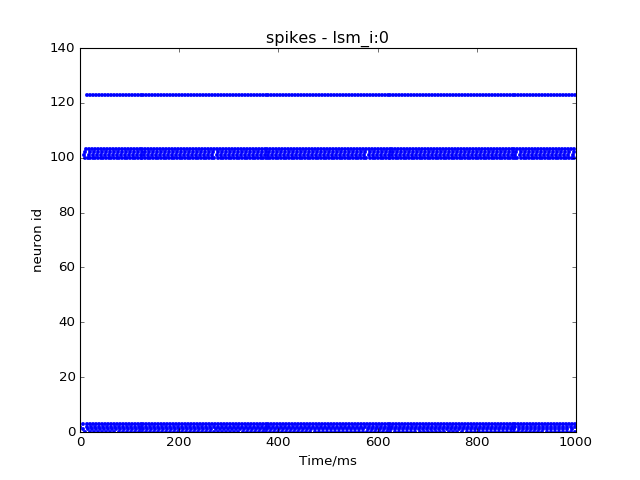

<IPython.core.display.Javascript object>


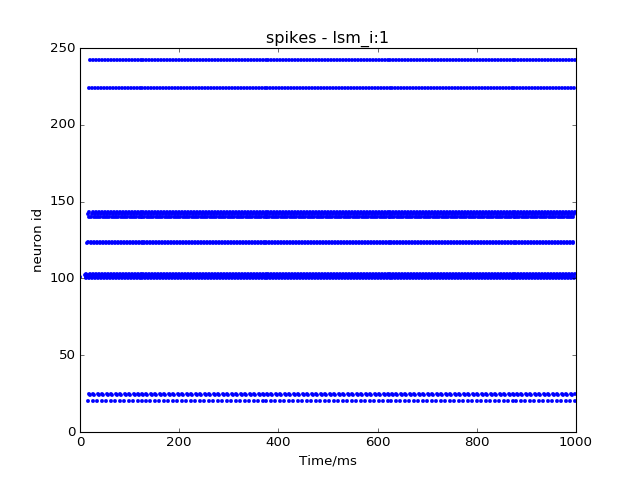

No spikes on lsm_i: 2
No spikes on lsm_i: 3
No spikes on lsm_i: 4


In [23]:
for lsm_i in range(number_of_liquids):
    if len(times[lsm_i]):
        plt.figure()
        plt.plot(times[lsm_i],spikes[lsm_i],'.')
        plt.ylabel('neuron id')
        plt.xlabel('Time/ms')
        plt.title('spikes - lsm_i:'+str(lsm_i))
        plt.show()
    else:
        print "No spikes on lsm_i:",lsm_i

In [24]:
#
# All messages generated by C code will not be printed inside the notebook!
#
# Proof:

import sys
import ctypes
libc = ctypes.CDLL(None)

from __future__ import print_function
print('hi, stdout', file=sys.stdout)
print('hi, stderr', file=sys.stderr)
ret_value = libc.puts(b"hello") # the C code prints only on the terminal...

hi, stdout


hi, stderr
